In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam

In [8]:
data = pd.read_csv('data.csv')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [9]:
data

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,0.477011,0.250000,0.0,0.0,0.686747,0.587312,0.782917,0.0,...,0.0,0.750000,0.0,0.0,0.271318,0.109500,4,1,2,0.540166
20627,100,197,0.408046,0.083333,0.0,0.0,0.701807,0.729453,0.866475,0.0,...,0.0,0.583333,0.0,0.0,0.124031,0.366197,3,1,2,0.542936
20628,100,198,0.522989,0.500000,0.0,0.0,0.665663,0.684979,0.775321,0.0,...,0.0,0.833333,0.0,0.0,0.232558,0.053991,2,1,2,0.545706
20629,100,199,0.436782,0.750000,0.0,0.0,0.608434,0.746021,0.747468,0.0,...,0.0,0.583333,0.0,0.0,0.116279,0.234466,1,1,2,0.548476


In [10]:
def build_generator(latent_dim, data_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(data_dim, activation='sigmoid'))
    return model

In [11]:
def build_discriminator(data_dim):
    model = Sequential()
    model.add(Dense(512, input_dim=data_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
latent_dim = 100
data_dim = data_scaled.shape[1]

generator = build_generator(latent_dim, data_dim)
discriminator = build_discriminator(data_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

gan = Sequential()
gan.add(generator)
gan.add(discriminator)
discriminator.trainable = False
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [13]:
def train_gan(gan, generator, discriminator, data, epochs=5000, batch_size=32):
    for epoch in range(epochs):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        gen_data = generator.predict(noise)

        idx = np.random.randint(0, data.shape[0], batch_size)
        real_data = data[idx]

        d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_data, np.zeros((batch_size, 1)))

        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f"{epoch}/{epochs} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]")

train_gan(gan, generator, discriminator, data_scaled)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
1000/5000 [D loss: [0.68810436 0.515625  ]] [G loss: 0.7602813243865967]
1/1 [==============================] - 0s 16ms/step
2000/5000 [D loss: [0.70264849 0.421875  ]] [G loss: 0.7160254716873169]
1/1 [==============================] - 0s 19ms/step
3000/5000 [D loss: [0.69304618 0.40625   ]] [G loss: 0.7039957642555237]
1/1 [==============================] - 0s 16ms/step
4000/5000 [D loss: [0.66172451 0.625     ]] [G loss: 0.8099204897880554]
1/1 [==============================] - 0s 17ms/step


In [14]:
noise = np.random.normal(0, 1, (40000, latent_dim))
synthetic_data = generator.predict(noise)
synthetic_data = scaler.inverse_transform(synthetic_data)
synthetic_data_df = pd.DataFrame(synthetic_data, columns=data.columns)

1250/1250 [==============================] - 2s 1ms/step


In [15]:
synthetic_data_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,95.607918,202.335632,0.324535,0.945184,7.956040e-10,8.758390e-10,0.779679,0.430384,0.484391,2.062770e-09,...,2.006154e-09,0.119063,2.080182e-09,1.821927e-09,0.388140,0.679761,183.146729,3.220767e-17,7.054445e-09,0.696518
1,93.763565,85.355194,0.301015,0.939282,7.138740e-11,7.790954e-11,0.744748,0.372638,0.478885,1.845137e-10,...,3.067163e-10,0.116272,1.781956e-10,1.894005e-10,0.403522,0.684682,239.126419,9.287890e-20,2.235589e-10,0.343573
2,74.238647,161.736801,0.391044,0.722017,1.186125e-05,1.609577e-05,0.626714,0.523735,0.573823,1.567670e-05,...,1.320938e-05,0.349057,1.768605e-05,1.220399e-05,0.421256,0.503782,73.406326,1.393346e-06,2.299778e-03,0.483279
3,49.118713,207.782181,0.489627,0.519684,2.126280e-06,2.766964e-06,0.616494,0.534663,0.687679,3.114260e-06,...,2.526840e-06,0.432789,3.255208e-06,2.712341e-06,0.347309,0.391575,13.766389,8.936941e-01,8.252509e-01,0.551129
4,82.033325,143.048111,0.432632,0.635866,2.030886e-06,1.655226e-06,0.590621,0.409554,0.433124,2.730592e-06,...,3.078398e-06,0.274436,2.900881e-06,3.020466e-06,0.454211,0.524158,152.552780,1.649333e-09,3.169341e-05,0.386353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,70.317184,109.219589,0.335443,0.793842,5.460186e-07,6.071048e-07,0.620743,0.405474,0.472286,7.200478e-07,...,9.696704e-07,0.210077,8.943823e-07,1.378640e-06,0.407102,0.541323,171.101837,4.037025e-11,5.807725e-06,0.308115
39996,70.590454,98.256859,0.393052,0.794831,1.702020e-07,1.184670e-07,0.611207,0.453618,0.535715,1.539052e-07,...,1.483216e-07,0.211861,2.222856e-07,1.592063e-07,0.375001,0.543736,105.626259,2.170191e-10,2.154798e-05,0.308503
39997,82.387634,71.244698,0.398074,0.713805,2.008262e-07,1.618213e-07,0.592502,0.353179,0.403876,3.074597e-07,...,2.708921e-07,0.217567,4.173156e-07,3.074377e-07,0.456559,0.679583,232.935394,1.480247e-13,2.145994e-07,0.236374
39998,90.968185,85.745422,0.326259,0.944217,1.203870e-10,1.499336e-10,0.764311,0.440119,0.502255,3.626409e-10,...,5.980831e-10,0.132470,2.843845e-10,4.365841e-10,0.404413,0.677585,225.268539,1.735340e-18,1.363524e-09,0.359213


In [16]:
output_file_path = "dcgan.csv"
synthetic_data_df.to_csv(output_file_path, index=False)
print(f"Data saved to {output_file_path}")

Data saved to dcgan.csv


In [18]:
!pip install table_evaluator

(20631, 30) (40000, 30)


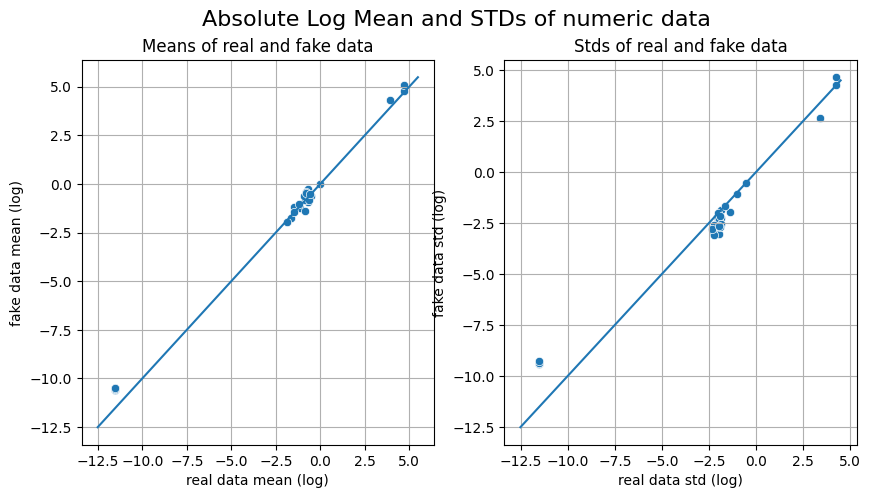

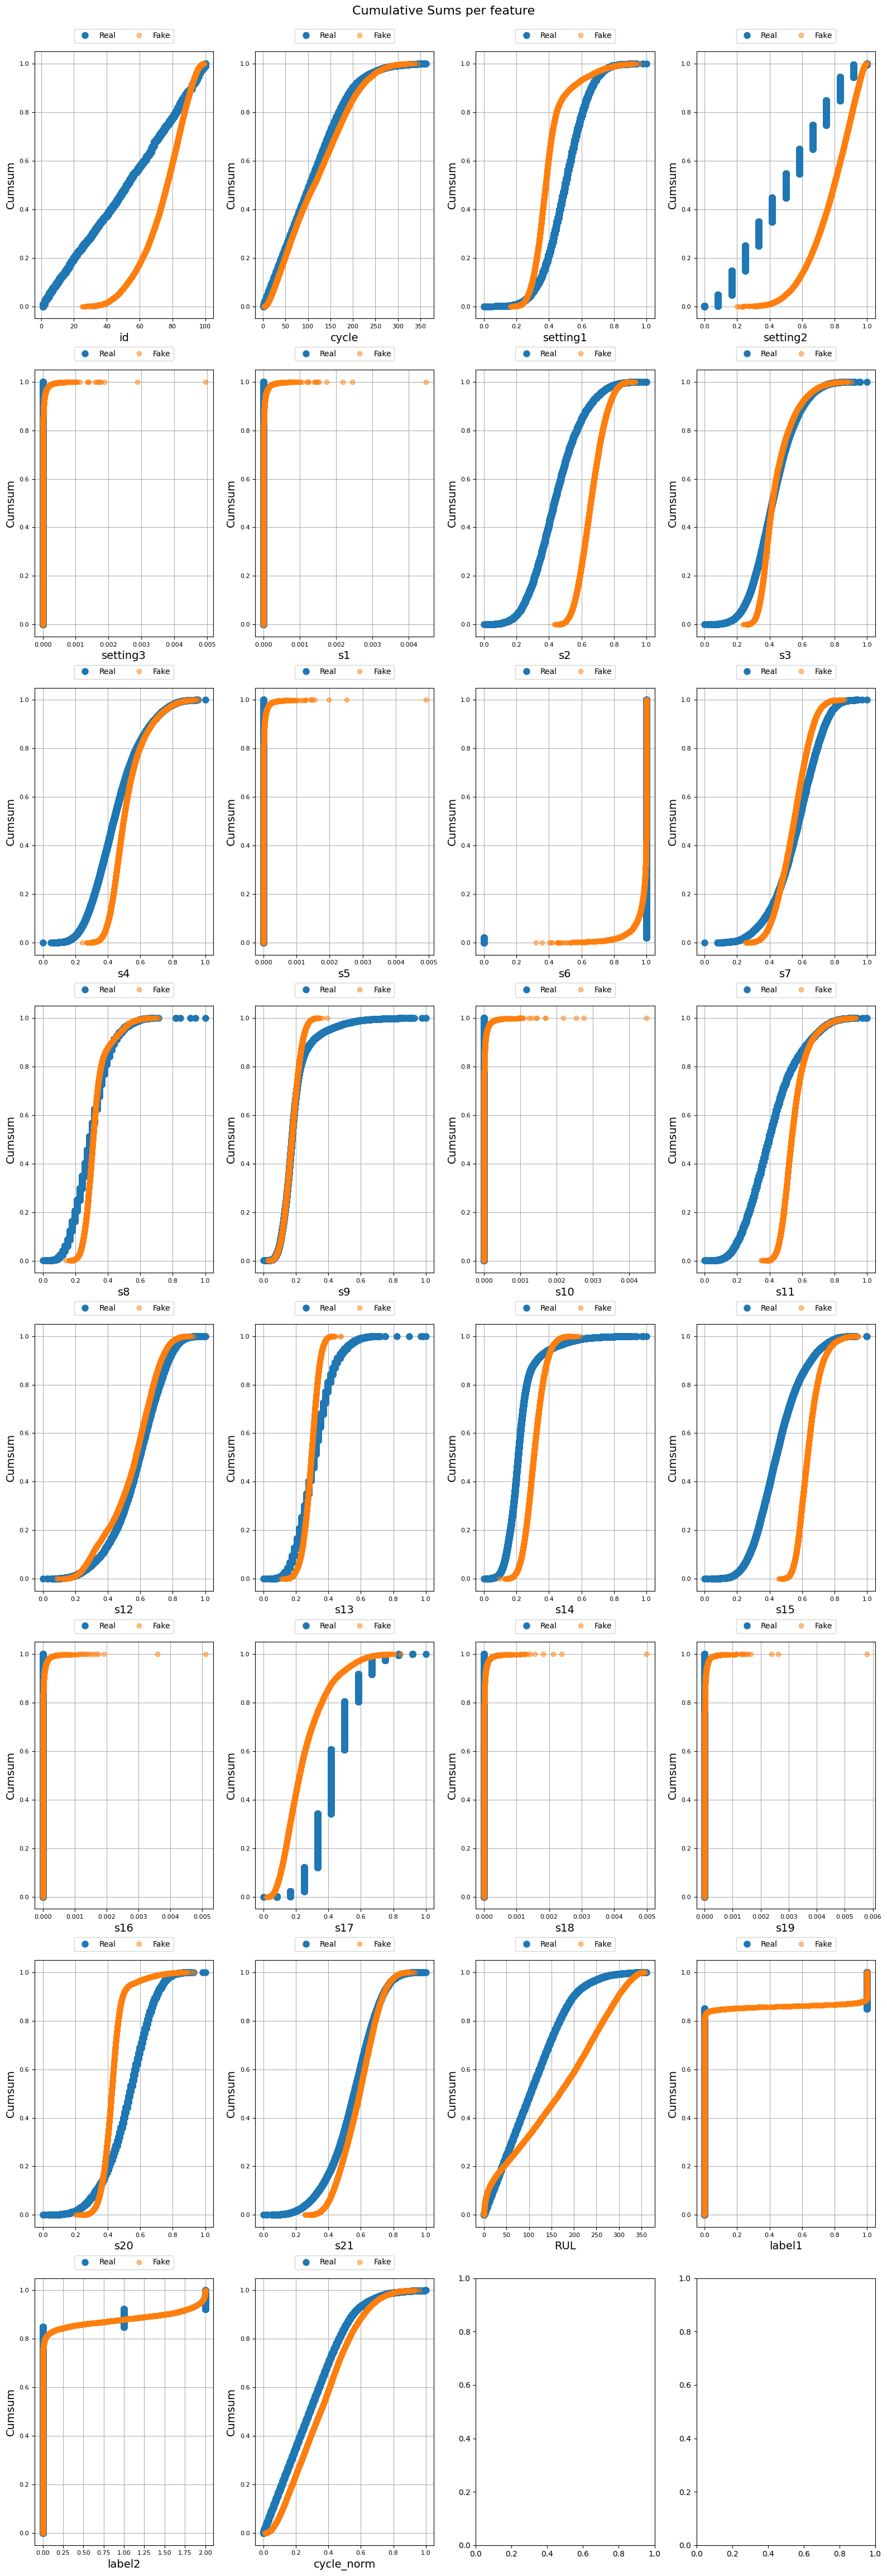

In [ ]:
from table_evaluator import TableEvaluator

print(data.shape, synthetic_data_df.shape)
table_evaluator =  TableEvaluator(data, synthetic_data_df)

table_evaluator.visual_evaluation()